In [35]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import random
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset

import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
from sklearn.metrics import accuracy_score


import torch
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
from keras import optimizers
from keras.layers import GlobalMaxPooling2D
from keras.models import load_model



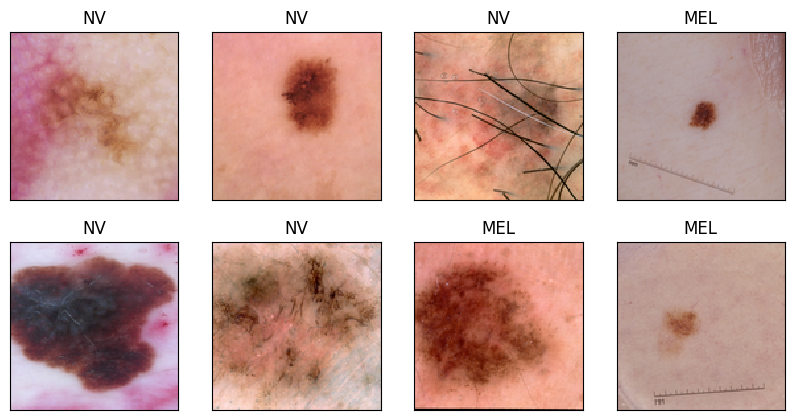

In [33]:
random.seed(1)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load images from the folder
folder_train = ImageFolder('./train', transform=transform)
folder_val = ImageFolder('./val', transform=transform)

# Create a DataLoader
train_loader = DataLoader(folder_train, batch_size=8, shuffle=True)
val_loader = DataLoader(folder_val, batch_size=8, shuffle=True)

folder_test = ImageFolder('./test', transform=transform)
test_loader = DataLoader(folder_test, batch_size=8, shuffle=True)

# Get a batch of examples
Xexamples, Yexamples = next(iter(train_loader))

# Plot the examples
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] == 0 else 'MEL')  # Assuming Yexamples is binary (0 or 1)
    plt.xticks([])
    plt.yticks([])

plt.show()



# train sample

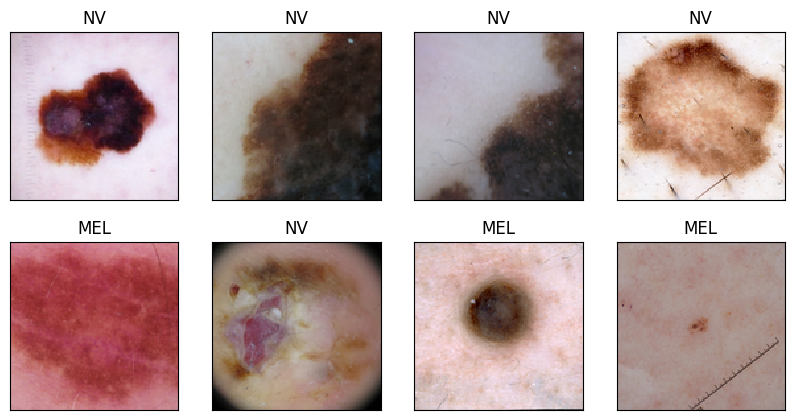

In [100]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# Shuffle the indices of the dataset
indices = np.arange(len(folder_train))
np.random.shuffle(indices)

# Select the first 100 indices
subset_indices = indices[:100]

# Create a DataLoader for the subset
train_loader_subset = DataLoader(folder_train, batch_size=8, sampler=SubsetRandomSampler(subset_indices))


# Get a batch of examples
Xexamples, Yexamples = next(iter(train_loader_subset))

# Plot the examples
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] == 0 else 'MEL')  # Assuming Yexamples is binary (0 or 1)
    plt.xticks([])
    plt.yticks([])

plt.show()



# Training and Validation

In [31]:
def evaluate_during_training(model, val_loader):
    model.eval()  # Set the model in evaluation mode
    all_gold = []
    all_pred = []

    with torch.no_grad():
        for Xbatch, Ybatch in val_loader:
            outputs = model(Xbatch)
            predictions = torch.round(outputs).squeeze()  # Assuming binary classification
            all_gold.extend(Ybatch.numpy())
            all_pred.extend(predictions.numpy())

    accuracy = accuracy_score(all_gold, all_pred)
    return accuracy


In [32]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, save_path):
    best_val_acc = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.eval()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss per sample
        val_acc = evaluate_during_training(model, val_loader)  # Evaluate on validation set

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

# Baseline

In [16]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch as torch


class Baseline_CNN(nn.Module):
    def __init__(self):
        super(Baseline_CNN, self).__init__()

        self.features = nn.Sequential(
            # 3: image input channel,3 channels RGB, Red Green Blue
            # 32 filters in the convoluational layer, output feature map = 32
            # relu for nonzero numbers to introduce non-linearity, helps mitigating the vanishing gradient problem
            # pooling to reduce spatial dimension

            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the output size after the convolutional layers
        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()

        )

    def forward(self, x):
      # print("Input size:", x.size())
      x = self.features(x)
      # print("After features size:", x.size())
      x = self.classifier(x)
      # print("Output size:", x.size())
      return x


In [ ]:
# Constants
learning_rate = 0.01
num_epochs = 10
save_path = "trained_models/baseline.pth"

# Initialize model, loss function, and optimizer
model_baseline = Baseline_CNN()
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optim.Adam(model_baseline.parameters(), lr=learning_rate)

# Call the training function
train_model(model_baseline, criterion, optimizer, train_loader, val_loader, num_epochs, save_path)

In [17]:
save_path = "trained_models/baseline.pth"
model_baseline = Baseline_CNN()
model_baseline.load_state_dict(torch.load(save_path))
model_baseline.eval()

val_acc = evaluate_during_training(model_baseline, val_loader)  # Evaluate on validation set
print("Baseline_CNN validation accuracy: ", val_acc)

Baseline_CNN validation accuracy:  0.7755591054313099


# Augmentation

In [6]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

folder_train = ImageFolder('./train', transform=transform)


R_channel = []
G_channel = []
B_channel = []


for img, _ in folder_train:
    img = img.numpy()
    R_channel.append(np.mean(img[0, :, :]))
    G_channel.append(np.mean(img[1, :, :]))
    B_channel.append(np.mean(img[2, :, :]))


mean = [np.mean(R_channel), np.mean(G_channel), np.mean(B_channel)]
std = [np.std(R_channel), np.std(G_channel), np.std(B_channel)]

print("Mean:", mean)
print("Std:", std)

Mean: [0.68368095, 0.5231375, 0.50991017]
Std: [0.15012987, 0.1178059, 0.12110886]


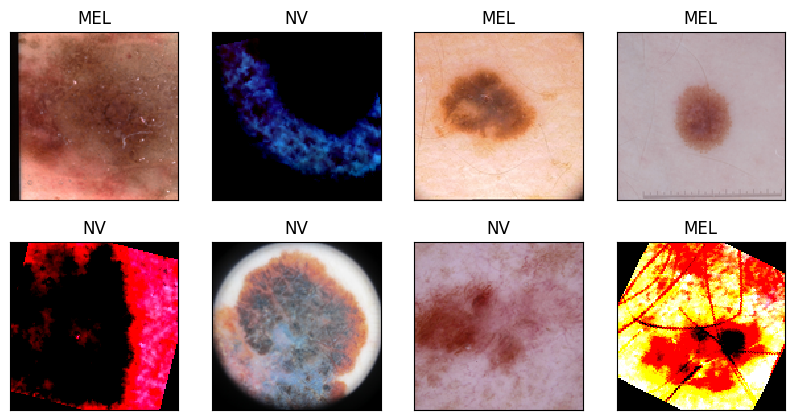

In [30]:
transform_augmented = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=(128, 128), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=35),  # Random rotation up to 15 degrees
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.68368095, 0.5231375, 0.50991017], std=[0.15012987, 0.1178059, 0.12110886]),
])


folder_train = ImageFolder('./train', transform=transform)
folder_train_augmented = ImageFolder('./train', transform=transform_augmented)

combined_dataset = ConcatDataset([folder_train, folder_train_augmented])

train_loader_augmented = DataLoader(combined_dataset, batch_size=16, shuffle=True)

Xexamples, Yexamples = next(iter(train_loader_augmented))


plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] == 0 else 'MEL')
    plt.xticks([])
    plt.yticks([])

plt.show()


In [8]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch as torch

class Augmented_CNN(nn.Module):
    def __init__(self):
        super(Augmented_CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with 50% probability
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [9]:
learning_rate = 0.001
num_epochs = 10
save_path = "trained_models/augmented.pth"

model_augmentation = Augmented_CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_augmentation.parameters(), lr=learning_rate, weight_decay=0.001)

train_model(model_augmentation, criterion, optimizer, train_loader_augmented, val_loader, num_epochs, save_path)

KeyboardInterrupt: 

In [31]:
save_path = "trained_models/augmented_.pth"
model_augmented = Augmented_CNN()
model_augmented.load_state_dict(torch.load(save_path))
criterion = nn.BCELoss()

val_acc = evaluate_during_training(model_augmented, val_loader)
print("Augmentated_CNN validation accuracy: ", val_acc)

Augmentated_CNN validation accuracy:  0.8162939297124601


# Residual

In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class Residual_CNN(nn.Module):
    def __init__(self):
        super(Residual_CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.residual_block1 = ResidualBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.residual_block2 = ResidualBlock(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.residual_block3 = ResidualBlock(64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.residual_block1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.residual_block2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.residual_block3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        return torch.sigmoid(x)


In [38]:
learning_rate = 0.001
num_epochs = 10
save_path = "trained_models/residual.pth"

model_residual = Residual_CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_residual.parameters(), lr=learning_rate)

train_model(model_residual, criterion, optimizer, train_loader, val_loader, num_epochs, save_path)

TypeError: 'module' object is not callable

In [46]:
save_path = "trained_models/residual.pth"
model_residual = Residual_CNN()
model_residual.load_state_dict(torch.load(save_path))
model_residual.eval()

val_acc = evaluate_during_training(model_residual, val_loader)
print("Residual validation accuracy: ", val_acc)

KeyboardInterrupt: 

# Batch Normalization

In [35]:
class BatchNormalizedCNN(nn.Module):
  def __init__(self):
        super(BatchNormalizedCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

In [77]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch as torch

learning_rate = 0.001
num_epochs = 10
save_path = "trained_models/batch_norm.pth"

model_batch_norm = BatchNormalizedCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_batch_norm.parameters(), lr=learning_rate)

train_model(model_batch_norm, criterion, optimizer, train_loader, val_loader, num_epochs, save_path)

Epoch 1/10, Loss: 0.5025, Validation Accuracy: 0.7604
Model saved at trained_models/batch_norm.pth


Epoch 2/10, Loss: 0.4280, Validation Accuracy: 0.7963
Model saved at trained_models/batch_norm.pth


Epoch 3/10, Loss: 0.3919, Validation Accuracy: 0.7979
Model saved at trained_models/batch_norm.pth


Epoch 4/10, Loss: 0.3778, Validation Accuracy: 0.8051
Model saved at trained_models/batch_norm.pth


Epoch 5/10, Loss: 0.3711, Validation Accuracy: 0.8115
Model saved at trained_models/batch_norm.pth


Epoch 6/10, Loss: 0.3641, Validation Accuracy: 0.8027


Epoch 7/10, Loss: 0.3517, Validation Accuracy: 0.7939


Epoch 8/10, Loss: 0.3435, Validation Accuracy: 0.8227
Model saved at trained_models/batch_norm.pth


Epoch 9/10, Loss: 0.3341, Validation Accuracy: 0.8371
Model saved at trained_models/batch_norm.pth


Epoch 10/10, Loss: 0.3259, Validation Accuracy: 0.8227


In [36]:
save_path = "trained_models/batch_norm.pth"
model_batch_norm = BatchNormalizedCNN()
model_batch_norm.load_state_dict(torch.load(save_path))
model_batch_norm.eval()

val_acc = evaluate_during_training(model_batch_norm, val_loader)
print("BatchNormalizedCNN validation accuracy: ", val_acc)

BatchNormalizedCNN validation accuracy:  0.8370607028753994


# Transfer Learning

In [6]:
import torch
import shutil

In [55]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import GlobalMaxPooling2D

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


IMAGE_SIZE = [224, 224]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(1, activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [56]:
train_path = 'train'
val_path = 'val'
batch_size = 8

rescale_factor = 1.0 / 255

train_datagen_augmented = ImageDataGenerator(
    rescale=rescale_factor,
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_datagen_normal = ImageDataGenerator(
    rescale=rescale_factor,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(
    rescale=rescale_factor,
    preprocessing_function=preprocess_input)


train_set_augmented = train_datagen_augmented.flow_from_directory(
                                              train_path,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True)

train_set_normal = train_datagen_normal.flow_from_directory(train_path,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True)


# Concatenate augmented and normal data
train_data_augmented, train_labels_augmented = next(train_set_augmented)
train_data_normal, train_labels_normal = next(train_set_normal)

combined_train_data = np.concatenate((train_data_augmented, train_data_normal))
combined_train_labels = np.concatenate((train_labels_augmented, train_labels_normal))

# Shuffle combined data
combined_indices = np.arange(combined_train_data.shape[0])
np.random.shuffle(combined_indices)

combined_train_data = combined_train_data[combined_indices]
combined_train_labels = combined_train_labels[combined_indices]


val_set = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          shuffle=True)

Found 6426 images belonging to 2 classes.
Found 6426 images belonging to 2 classes.
Found 1252 images belonging to 2 classes.


## Training

In [42]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


file_path = 'trained_models/vgg16_transfer_learning_normal.keras'

# Define callbacks
checkpoint = ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

# Train the model with callbacks
model_history = model.fit(
    train_set_normal,
    validation_data=val_set,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


804/804 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8147
Epoch 1: val_loss improved from inf to 0.38271, saving model to trained_models\vgg16_transfer_learning_normal.keras
804/804 [==============================] - 369s 459ms/step - loss: 0.4072 - accuracy: 0.8147 - val_loss: 0.3827 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 2/100
804/804 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8596
Epoch 2: val_loss did not improve from 0.38271
804/804 [==============================] - 364s 452ms/step - loss: 0.3157 - accuracy: 0.8596 - val_loss: 0.4203 - val_accuracy: 0.8179 - lr: 0.0010
Epoch 3/100
804/804 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.8705
Epoch 3: val_loss did not improve from 0.38271
804/804 [==============================] - 369s 459ms/step - loss: 0.2909 - accuracy: 0.8705 - val_loss: 0.6162 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 4/100
804/804 [==============================] - ETA: 0s - lo

In [43]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


file_path = 'trained_models/vgg16_transfer_learning_augmented.keras'

# Define callbacks
checkpoint = ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

# Train the model with callbacks
model_history = model.fit(
    train_set_augmented,
    validation_data=val_set,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
804/804 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8293
Epoch 1: val_loss improved from inf to 0.32641, saving model to trained_models\vgg16_transfer_learning_augmented.keras
804/804 [==============================] - 363s 451ms/step - loss: 0.3684 - accuracy: 0.8293 - val_loss: 0.3264 - val_accuracy: 0.8586 - lr: 4.0000e-05
Epoch 2/100
804/804 [==============================] - ETA: 0s - loss: 0.3690 - accuracy: 0.8307
Epoch 2: val_loss improved from 0.32641 to 0.32131, saving model to trained_models\vgg16_transfer_learning_augmented.keras
804/804 [==============================] - 364s 453ms/step - loss: 0.3690 - accuracy: 0.8307 - val_loss: 0.3213 - val_accuracy: 0.8562 - lr: 4.0000e-05
Epoch 3/100
804/804 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8270
Epoch 3: val_loss improved from 0.32131 to 0.32088, saving model to trained_models\vgg16_transfer_learning_augmented.keras
804/804 [==============================]

In [44]:

file_path = 'trained_models/vgg16_transfer_learning_norm_aug.keras'

# Define callbacks
checkpoint = ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

# Train the model with callbacks
model_history = model.fit(
    x = combined_train_data,
    y = combined_train_labels,
    validation_data=val_set,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.31495, saving model to trained_models\vgg16_transfer_learning_norm_aug.keras
1/1 [==============================] - 56s 56s/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.3150 - val_accuracy: 0.8482 - lr: 1.0000e-06
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.31495 to 0.31495, saving model to trained_models\vgg16_transfer_learning_norm_aug.keras
1/1 [==============================] - 55s 55s/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.3149 - val_accuracy: 0.8482 - lr: 1.0000e-06
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.31495 to 0.31494, saving model to trained_models\vgg16_transfer_learning_norm_aug.keras
1/1 [==============================] - 55s 55s/step - loss: 0.0809 - 

In [57]:
file_path = 'trained_models/vgg16_transfer_learning_normal_unfreeze.keras'

for layer in model.layers[:]:  # Freeze layers up to the last 4 layers
    layer.trainable = False

# Define callbacks
checkpoint = ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

# Train the model with callbacks
model_history = model.fit(
    train_data_normal,
    validation_data=val_set,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1152, in train_step
        self._validate_target_and_loss(y, loss)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1106, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=binary_crossentropy, and therefore expects target data to be provided in `fit()`.


## Validation on validation set

In [318]:
train_path = 'train'
val_path = 'val'
from keras.models import load_model


test_set = val_datagen.flow_from_directory(val_path,
                                            target_size=(128, 128),
                                            batch_size=32,
                                            class_mode='categorical')

print("="*100)
print("Training 1:")
# Load the trained model
model = load_model('trained_models/vgg16_transfer_learning.keras')
# Evaluate the model on the validation set
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)


print("="*100)
print("Training 2:")
# Load the trained model
model = load_model('trained_models/vgg16_transfer_learning_2.keras')
# Evaluate the model on the validation set
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)



print("="*100)
print("Training 2:")
# Load the trained model
model = load_model('trained_models/vgg16_transfer_learning_3.keras')
# Evaluate the model on the validation set
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)

Found 1252 images belonging to 2 classes.


Training 1:
40/40 [==============================] - 19s 466ms/step - loss: 0.6403 - accuracy: 0.8131
Evaluation Metrics on Validation Set: [0.6403016448020935, 0.8130990266799927]
Training 2:
40/40 [==============================] - 19s 455ms/step - loss: 2.0410 - accuracy: 0.7987
Evaluation Metrics on Validation Set: [2.0409765243530273, 0.7987220287322998]
Training 2:
40/40 [==============================] - 19s 459ms/step - loss: 0.3433 - accuracy: 0.8419
Evaluation Metrics on Validation Set: [0.3432927131652832, 0.8418530225753784]


## Validation on blind set

In [11]:
from keras.models import load_model

model = load_model('trained_models/vgg16_transfer_learning_3.keras')

evaluation_data_path = 'test_blind'
evaluation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

evaluation_set = evaluation_datagen.flow_from_directory(evaluation_data_path,
                                                        target_size=(128, 128),
                                                        batch_size=8,
                                                        class_mode=None,
                                                        shuffle=False)


predictions = model.predict(evaluation_set, verbose=1)


print("Predictions:")
print(predictions)




Found 1366 images belonging to 1 classes.
171/171 [==============================] - 25s 143ms/step
Predictions:
[[1.7590761e-06 3.0688559e-05]
 [1.7680595e-09 3.1036787e-10]
 [2.9659876e-01 1.0304617e-01]
 ...
 [5.0589350e-09 1.0259620e-08]
 [9.9671096e-01 9.6899211e-01]
 [1.2098124e-20 2.3636651e-24]]


In [12]:
output_file = open("predictions.txt", "w")
for i, prediction in enumerate(predictions):
    if prediction[0] > 0.5:  # Assuming index 0 corresponds to the "MEL" class
        output_file.write( "NV\n")
    else:
        output_file.write( "MEL\n")
output_file.close()

## Test if it works

In [13]:
with open('predictions.txt') as f:
    guesses = [l.strip() for l in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])

In [14]:
# Open the text file for reading
with open("predictions.txt", "r") as file:
    # Initialize counters
    count_NV = 0
    count_MEL = 0

    # Iterate through each line in the file
    for line in file:
        # Check if the line contains "NV" or "MEL" and increment the corresponding counter
        if "NV" in line:
            count_NV += 1
        elif "MEL" in line:
            count_MEL += 1

# Print the counts
print("Number of NV entries:", count_NV)
print("Number of MEL entries:", count_MEL)


Number of NV entries: 116
Number of MEL entries: 1250


# Finetuned model

In [10]:
import torch.nn as nn

class Finetuned_CNN(nn.Module):
    def __init__(self):
        super(Finetuned_CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )


        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [11]:
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

# Shuffle the indices of the dataset
indices = np.arange(len(folder_train))
np.random.shuffle(indices)

# Take the first 100 and last 100 indices
subset_indices = np.concatenate((indices[:100], indices[-100:]))

# Create a DataLoader for the subset
train_loader_subset_2 = DataLoader(combined_dataset, batch_size=8, sampler=SubsetRandomSampler(subset_indices))


In [ ]:
class ModelCheckpoint:
    def __init__(self, filepath, save_best_only=True):
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.best_metric = float('inf') if save_best_only else None

    def step(self, model, metric):
        if self.save_best_only:
            if metric < self.best_metric:
                self.best_metric = metric
                torch.save(model.state_dict(), self.filepath)
                print(f"Model saved at {self.filepath}")
        else:
            torch.save(model.state_dict(), self.filepath)
            print(f"Model saved at {self.filepath}")

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau as TorchReduceLROnPlateau

class ReduceLROnPlateau:
    def __init__(self, optimizer, mode='min', factor=0.1, patience=10, threshold=1e-4, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8):
        self.scheduler = TorchReduceLROnPlateau(optimizer, mode=mode, factor=factor, patience=patience, threshold=threshold, threshold_mode=threshold_mode, cooldown=cooldown, min_lr=min_lr, eps=eps)

    def step(self, metric):
        self.scheduler.step(metric)

In [22]:
def train_model_finetuned(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, save_path):
    best_val_acc = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)  # Calculate average loss per sample
        val_acc = evaluate_during_training(model, val_loader)  # Evaluate on validation set

        current_lr = optimizer.param_groups[0]['lr']
        print("Current learning rate:", current_lr)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

        scheduler.step(val_acc)

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

learning_rate = 0.0001  # Initial learning rate
num_epochs = 1000  # Number of training epochs
save_path = "trained_models/finetuned_.pth"  # Path to save the trained model
weight_decay = 1e-6  # Weight decay regularization strength
patience = 50  # Patience for early stopping
min_lr = 1e-6

# Initialize model, loss function, optimizer
model_finetuned = Finetuned_CNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model_finetuned.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize scheduler for learning rate adjustment
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=30, min_lr=min_lr)

# Train the model with early stopping and weight restoration
train_model_finetuned(model_finetuned, criterion, optimizer, scheduler, train_loader_augmented, val_loader, num_epochs, save_path)


Current learning rate: 0.0001
Epoch 1/1000, Loss: 0.5584, Validation Accuracy: 0.7548
Model saved at trained_models/finetuned_.pth


Current learning rate: 0.0001
Epoch 2/1000, Loss: 0.5003, Validation Accuracy: 0.7588
Model saved at trained_models/finetuned_.pth


KeyboardInterrupt: 

In [329]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

learning_rate = 0.0001  # Initial learning rate
num_epochs = 1000  # Number of training epochs
save_path = "trained_models/finetuned2313.pth"  # Path to save the trained model
weight_decay = 1e-6  # Weight decay regularization strength

# Initialize model, loss function, optimizer, and scheduler
model_finetuned = Finetuned_CNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model_finetuned.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=30)  # Reduce learning rate when a metric has stopped improving

train_model_finetuned(model_finetuned, criterion, optimizer, scheduler, train_loader_augmented, val_loader, num_epochs, save_path)

Current learning rate: 0.0001
Epoch 1/1000, Loss: 0.5474, Validation Accuracy: 0.7684
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 2/1000, Loss: 0.4839, Validation Accuracy: 0.8083
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 3/1000, Loss: 0.4584, Validation Accuracy: 0.8051


Current learning rate: 0.0001
Epoch 4/1000, Loss: 0.4560, Validation Accuracy: 0.8211
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 5/1000, Loss: 0.4433, Validation Accuracy: 0.8171


Current learning rate: 0.0001
Epoch 6/1000, Loss: 0.4389, Validation Accuracy: 0.8259
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 7/1000, Loss: 0.4327, Validation Accuracy: 0.8419
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 8/1000, Loss: 0.4338, Validation Accuracy: 0.8315


Current learning rate: 0.0001
Epoch 9/1000, Loss: 0.4260, Validation Accuracy: 0.8203


Current learning rate: 0.0001
Epoch 10/1000, Loss: 0.4230, Validation Accuracy: 0.8307


Current learning rate: 0.0001
Epoch 11/1000, Loss: 0.4281, Validation Accuracy: 0.8267


Current learning rate: 0.0001
Epoch 12/1000, Loss: 0.4172, Validation Accuracy: 0.8251


Current learning rate: 0.0001
Epoch 13/1000, Loss: 0.4171, Validation Accuracy: 0.8355


Current learning rate: 0.0001
Epoch 14/1000, Loss: 0.4108, Validation Accuracy: 0.8115


Current learning rate: 0.0001
Epoch 15/1000, Loss: 0.4093, Validation Accuracy: 0.8091


Current learning rate: 0.0001
Epoch 16/1000, Loss: 0.4060, Validation Accuracy: 0.8371


Current learning rate: 0.0001
Epoch 17/1000, Loss: 0.4018, Validation Accuracy: 0.8307


Current learning rate: 0.0001
Epoch 18/1000, Loss: 0.4015, Validation Accuracy: 0.8227


Current learning rate: 0.0001
Epoch 19/1000, Loss: 0.3954, Validation Accuracy: 0.8227


Current learning rate: 0.0001
Epoch 20/1000, Loss: 0.3992, Validation Accuracy: 0.8379


Current learning rate: 0.0001
Epoch 21/1000, Loss: 0.3973, Validation Accuracy: 0.8387


Current learning rate: 0.0001
Epoch 22/1000, Loss: 0.3933, Validation Accuracy: 0.8307


Current learning rate: 0.0001
Epoch 23/1000, Loss: 0.3927, Validation Accuracy: 0.8498
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 24/1000, Loss: 0.3895, Validation Accuracy: 0.8259


Current learning rate: 0.0001
Epoch 25/1000, Loss: 0.3893, Validation Accuracy: 0.8379


Current learning rate: 0.0001
Epoch 26/1000, Loss: 0.3890, Validation Accuracy: 0.8123


Current learning rate: 0.0001
Epoch 27/1000, Loss: 0.3865, Validation Accuracy: 0.8442


Current learning rate: 0.0001
Epoch 28/1000, Loss: 0.3849, Validation Accuracy: 0.8450


Current learning rate: 0.0001
Epoch 29/1000, Loss: 0.3861, Validation Accuracy: 0.7796


Current learning rate: 0.0001
Epoch 30/1000, Loss: 0.3855, Validation Accuracy: 0.8331


Current learning rate: 0.0001
Epoch 31/1000, Loss: 0.3818, Validation Accuracy: 0.8466


Current learning rate: 0.0001
Epoch 32/1000, Loss: 0.3835, Validation Accuracy: 0.8403


Current learning rate: 0.0001
Epoch 33/1000, Loss: 0.3823, Validation Accuracy: 0.8427


Current learning rate: 0.0001
Epoch 34/1000, Loss: 0.3789, Validation Accuracy: 0.8490


Current learning rate: 0.0001
Epoch 35/1000, Loss: 0.3730, Validation Accuracy: 0.8403


Current learning rate: 0.0001
Epoch 36/1000, Loss: 0.3715, Validation Accuracy: 0.8514
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 37/1000, Loss: 0.3730, Validation Accuracy: 0.8387


Current learning rate: 0.0001
Epoch 38/1000, Loss: 0.3715, Validation Accuracy: 0.8291


Current learning rate: 0.0001
Epoch 39/1000, Loss: 0.3678, Validation Accuracy: 0.8427


Current learning rate: 0.0001
Epoch 40/1000, Loss: 0.3719, Validation Accuracy: 0.8578
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 41/1000, Loss: 0.3757, Validation Accuracy: 0.8562


Current learning rate: 0.0001
Epoch 42/1000, Loss: 0.3685, Validation Accuracy: 0.8339


Current learning rate: 0.0001
Epoch 43/1000, Loss: 0.3697, Validation Accuracy: 0.8403


Current learning rate: 0.0001
Epoch 44/1000, Loss: 0.3673, Validation Accuracy: 0.8610
Model saved at trained_models/finetuned.pth


Current learning rate: 0.0001
Epoch 45/1000, Loss: 0.3642, Validation Accuracy: 0.8267


Current learning rate: 0.0001
Epoch 46/1000, Loss: 0.3663, Validation Accuracy: 0.8506


Current learning rate: 0.0001
Epoch 47/1000, Loss: 0.3638, Validation Accuracy: 0.8522


Current learning rate: 0.0001
Epoch 48/1000, Loss: 0.3593, Validation Accuracy: 0.8419


Current learning rate: 0.0001
Epoch 49/1000, Loss: 0.3636, Validation Accuracy: 0.8554


Current learning rate: 0.0001
Epoch 50/1000, Loss: 0.3586, Validation Accuracy: 0.8315


Current learning rate: 0.0001
Epoch 51/1000, Loss: 0.3585, Validation Accuracy: 0.8435


Current learning rate: 0.0001
Epoch 52/1000, Loss: 0.3570, Validation Accuracy: 0.8363


Current learning rate: 0.0001
Epoch 53/1000, Loss: 0.3541, Validation Accuracy: 0.8530


Current learning rate: 0.0001
Epoch 54/1000, Loss: 0.3498, Validation Accuracy: 0.8538


Current learning rate: 0.0001
Epoch 55/1000, Loss: 0.3570, Validation Accuracy: 0.8506


Current learning rate: 0.0001
Epoch 56/1000, Loss: 0.3519, Validation Accuracy: 0.8554


Current learning rate: 0.0001
Epoch 57/1000, Loss: 0.3527, Validation Accuracy: 0.8514


Current learning rate: 0.0001
Epoch 58/1000, Loss: 0.3493, Validation Accuracy: 0.8307


Current learning rate: 0.0001
Epoch 59/1000, Loss: 0.3451, Validation Accuracy: 0.8602


Current learning rate: 0.0001
Epoch 60/1000, Loss: 0.3494, Validation Accuracy: 0.8578


Current learning rate: 0.0001
Epoch 61/1000, Loss: 0.3451, Validation Accuracy: 0.8107


Current learning rate: 0.0001
Epoch 62/1000, Loss: 0.3495, Validation Accuracy: 0.8427


Current learning rate: 0.0001
Epoch 63/1000, Loss: 0.3433, Validation Accuracy: 0.8570


Current learning rate: 0.0001
Epoch 64/1000, Loss: 0.3374, Validation Accuracy: 0.8530


Current learning rate: 0.0001
Epoch 65/1000, Loss: 0.3416, Validation Accuracy: 0.8363


Current learning rate: 0.0001
Epoch 66/1000, Loss: 0.3426, Validation Accuracy: 0.8347


Current learning rate: 0.0001
Epoch 67/1000, Loss: 0.3362, Validation Accuracy: 0.8602


Current learning rate: 0.0001
Epoch 68/1000, Loss: 0.3423, Validation Accuracy: 0.8538


Current learning rate: 0.0001
Epoch 69/1000, Loss: 0.3405, Validation Accuracy: 0.8139


Current learning rate: 0.0001
Epoch 70/1000, Loss: 0.3356, Validation Accuracy: 0.8530


Current learning rate: 0.0001
Epoch 71/1000, Loss: 0.3352, Validation Accuracy: 0.8570


Current learning rate: 0.0001
Epoch 72/1000, Loss: 0.3256, Validation Accuracy: 0.8419


Current learning rate: 0.0001
Epoch 73/1000, Loss: 0.3394, Validation Accuracy: 0.8474


Current learning rate: 0.0001
Epoch 74/1000, Loss: 0.3271, Validation Accuracy: 0.8482


Current learning rate: 0.0001
Epoch 75/1000, Loss: 0.3341, Validation Accuracy: 0.8435


Current learning rate: 1e-05
Epoch 76/1000, Loss: 0.3195, Validation Accuracy: 0.8506


Current learning rate: 1e-05
Epoch 77/1000, Loss: 0.3187, Validation Accuracy: 0.8490


Current learning rate: 1e-05
Epoch 78/1000, Loss: 0.3187, Validation Accuracy: 0.8514


Current learning rate: 1e-05
Epoch 79/1000, Loss: 0.3148, Validation Accuracy: 0.8554


Current learning rate: 1e-05
Epoch 80/1000, Loss: 0.3073, Validation Accuracy: 0.8554


Current learning rate: 1e-05
Epoch 81/1000, Loss: 0.3149, Validation Accuracy: 0.8578


Current learning rate: 1e-05
Epoch 82/1000, Loss: 0.3120, Validation Accuracy: 0.8514


Current learning rate: 1e-05
Epoch 83/1000, Loss: 0.3096, Validation Accuracy: 0.8427


Current learning rate: 1e-05
Epoch 84/1000, Loss: 0.3055, Validation Accuracy: 0.8395


Current learning rate: 1e-05
Epoch 85/1000, Loss: 0.3079, Validation Accuracy: 0.8179


Current learning rate: 1e-05
Epoch 86/1000, Loss: 0.3029, Validation Accuracy: 0.8506


Current learning rate: 1e-05
Epoch 87/1000, Loss: 0.3065, Validation Accuracy: 0.8458


Current learning rate: 1e-05
Epoch 88/1000, Loss: 0.3015, Validation Accuracy: 0.8578


Current learning rate: 1e-05
Epoch 89/1000, Loss: 0.3040, Validation Accuracy: 0.8411


Current learning rate: 1e-05
Epoch 90/1000, Loss: 0.3100, Validation Accuracy: 0.8514


Current learning rate: 1e-05
Epoch 91/1000, Loss: 0.2942, Validation Accuracy: 0.8395


Current learning rate: 1e-05
Epoch 92/1000, Loss: 0.3033, Validation Accuracy: 0.8490


Current learning rate: 1e-05
Epoch 93/1000, Loss: 0.3010, Validation Accuracy: 0.8458


Current learning rate: 1e-05
Epoch 94/1000, Loss: 0.3087, Validation Accuracy: 0.8570


Current learning rate: 1e-05
Epoch 95/1000, Loss: 0.3072, Validation Accuracy: 0.8474


Current learning rate: 1e-05
Epoch 96/1000, Loss: 0.3066, Validation Accuracy: 0.8435


Current learning rate: 1e-05
Epoch 97/1000, Loss: 0.3057, Validation Accuracy: 0.8522


Current learning rate: 1e-05
Epoch 98/1000, Loss: 0.3047, Validation Accuracy: 0.8554


Current learning rate: 1e-05
Epoch 99/1000, Loss: 0.2971, Validation Accuracy: 0.8482


Current learning rate: 1e-05
Epoch 100/1000, Loss: 0.3022, Validation Accuracy: 0.8482


Current learning rate: 1e-05
Epoch 101/1000, Loss: 0.2996, Validation Accuracy: 0.8474


Current learning rate: 1e-05
Epoch 102/1000, Loss: 0.3043, Validation Accuracy: 0.8522


Current learning rate: 1e-05
Epoch 103/1000, Loss: 0.3017, Validation Accuracy: 0.8458


Current learning rate: 1e-05
Epoch 104/1000, Loss: 0.3064, Validation Accuracy: 0.8514


Current learning rate: 1e-05
Epoch 105/1000, Loss: 0.2970, Validation Accuracy: 0.8458


Current learning rate: 1e-05
Epoch 106/1000, Loss: 0.3043, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-06
Epoch 107/1000, Loss: 0.2998, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000002e-06
Epoch 108/1000, Loss: 0.2991, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000002e-06
Epoch 109/1000, Loss: 0.3018, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000002e-06
Epoch 110/1000, Loss: 0.2972, Validation Accuracy: 0.8403


Current learning rate: 1.0000000000000002e-06
Epoch 111/1000, Loss: 0.2930, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000002e-06
Epoch 112/1000, Loss: 0.2987, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-06
Epoch 113/1000, Loss: 0.3018, Validation Accuracy: 0.8331


Current learning rate: 1.0000000000000002e-06
Epoch 114/1000, Loss: 0.2958, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000002e-06
Epoch 115/1000, Loss: 0.2970, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000002e-06
Epoch 116/1000, Loss: 0.3007, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000002e-06
Epoch 117/1000, Loss: 0.2954, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000002e-06
Epoch 118/1000, Loss: 0.2986, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-06
Epoch 119/1000, Loss: 0.3025, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000002e-06
Epoch 120/1000, Loss: 0.2958, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000002e-06
Epoch 121/1000, Loss: 0.2960, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000002e-06
Epoch 122/1000, Loss: 0.2898, Validation Accuracy: 0.8395


Current learning rate: 1.0000000000000002e-06
Epoch 123/1000, Loss: 0.2990, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000002e-06
Epoch 124/1000, Loss: 0.3061, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-06
Epoch 125/1000, Loss: 0.2998, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000002e-06
Epoch 126/1000, Loss: 0.2969, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000002e-06
Epoch 127/1000, Loss: 0.2971, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000002e-06
Epoch 128/1000, Loss: 0.2968, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000002e-06
Epoch 129/1000, Loss: 0.2998, Validation Accuracy: 0.8019


Current learning rate: 1.0000000000000002e-06
Epoch 130/1000, Loss: 0.2960, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000002e-06
Epoch 131/1000, Loss: 0.3005, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-06
Epoch 132/1000, Loss: 0.2995, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-06
Epoch 133/1000, Loss: 0.2968, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000002e-06
Epoch 134/1000, Loss: 0.2928, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000002e-06
Epoch 135/1000, Loss: 0.2927, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000002e-06
Epoch 136/1000, Loss: 0.2969, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000002e-06
Epoch 137/1000, Loss: 0.2990, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000002e-07
Epoch 138/1000, Loss: 0.3006, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000002e-07
Epoch 139/1000, Loss: 0.3020, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000002e-07
Epoch 140/1000, Loss: 0.3019, Validation Accuracy: 0.8395


Current learning rate: 1.0000000000000002e-07
Epoch 141/1000, Loss: 0.2972, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000002e-07
Epoch 142/1000, Loss: 0.3001, Validation Accuracy: 0.8347


Current learning rate: 1.0000000000000002e-07
Epoch 143/1000, Loss: 0.2919, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000002e-07
Epoch 144/1000, Loss: 0.3023, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000002e-07
Epoch 145/1000, Loss: 0.2944, Validation Accuracy: 0.8427


Current learning rate: 1.0000000000000002e-07
Epoch 146/1000, Loss: 0.2941, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000002e-07
Epoch 147/1000, Loss: 0.3040, Validation Accuracy: 0.8411


Current learning rate: 1.0000000000000002e-07
Epoch 148/1000, Loss: 0.3009, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000002e-07
Epoch 149/1000, Loss: 0.3001, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000002e-07
Epoch 150/1000, Loss: 0.2959, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000002e-07
Epoch 151/1000, Loss: 0.2975, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000002e-07
Epoch 152/1000, Loss: 0.2950, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-07
Epoch 153/1000, Loss: 0.2990, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000002e-07
Epoch 154/1000, Loss: 0.2959, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-07
Epoch 155/1000, Loss: 0.3005, Validation Accuracy: 0.8355


Current learning rate: 1.0000000000000002e-07
Epoch 156/1000, Loss: 0.2978, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000002e-07
Epoch 157/1000, Loss: 0.2999, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000002e-07
Epoch 158/1000, Loss: 0.2953, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000002e-07
Epoch 159/1000, Loss: 0.2953, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000002e-07
Epoch 160/1000, Loss: 0.2999, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000002e-07
Epoch 161/1000, Loss: 0.3020, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000002e-07
Epoch 162/1000, Loss: 0.3008, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000002e-07
Epoch 163/1000, Loss: 0.2926, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000002e-07
Epoch 164/1000, Loss: 0.2936, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000002e-07
Epoch 165/1000, Loss: 0.3015, Validation Accuracy: 0.8387


Current learning rate: 1.0000000000000002e-07
Epoch 166/1000, Loss: 0.2910, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000002e-07
Epoch 167/1000, Loss: 0.3026, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000002e-07
Epoch 168/1000, Loss: 0.2971, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 169/1000, Loss: 0.3003, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 170/1000, Loss: 0.3004, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 171/1000, Loss: 0.2975, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 172/1000, Loss: 0.3001, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000004e-08
Epoch 173/1000, Loss: 0.2995, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 174/1000, Loss: 0.2962, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 175/1000, Loss: 0.2939, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 176/1000, Loss: 0.3012, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 177/1000, Loss: 0.2990, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 178/1000, Loss: 0.3056, Validation Accuracy: 0.8379


Current learning rate: 1.0000000000000004e-08
Epoch 179/1000, Loss: 0.2963, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 180/1000, Loss: 0.2973, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 181/1000, Loss: 0.2995, Validation Accuracy: 0.8578


Current learning rate: 1.0000000000000004e-08
Epoch 182/1000, Loss: 0.2986, Validation Accuracy: 0.8387


Current learning rate: 1.0000000000000004e-08
Epoch 183/1000, Loss: 0.2958, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000004e-08
Epoch 184/1000, Loss: 0.2958, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 185/1000, Loss: 0.2974, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 186/1000, Loss: 0.2996, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 187/1000, Loss: 0.2972, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 188/1000, Loss: 0.2977, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000004e-08
Epoch 189/1000, Loss: 0.2978, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 190/1000, Loss: 0.2973, Validation Accuracy: 0.8291


Current learning rate: 1.0000000000000004e-08
Epoch 191/1000, Loss: 0.3091, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 192/1000, Loss: 0.2936, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 193/1000, Loss: 0.3014, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 194/1000, Loss: 0.2955, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000004e-08
Epoch 195/1000, Loss: 0.3035, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000004e-08
Epoch 196/1000, Loss: 0.2995, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 197/1000, Loss: 0.3003, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 198/1000, Loss: 0.2969, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 199/1000, Loss: 0.2969, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 200/1000, Loss: 0.2958, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 201/1000, Loss: 0.2986, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 202/1000, Loss: 0.2964, Validation Accuracy: 0.8403


Current learning rate: 1.0000000000000004e-08
Epoch 203/1000, Loss: 0.3004, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 204/1000, Loss: 0.2990, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 205/1000, Loss: 0.2964, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 206/1000, Loss: 0.2977, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 207/1000, Loss: 0.2945, Validation Accuracy: 0.8578


Current learning rate: 1.0000000000000004e-08
Epoch 208/1000, Loss: 0.2946, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 209/1000, Loss: 0.3025, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 210/1000, Loss: 0.2984, Validation Accuracy: 0.8427


Current learning rate: 1.0000000000000004e-08
Epoch 211/1000, Loss: 0.2996, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 212/1000, Loss: 0.2962, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 213/1000, Loss: 0.2953, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 214/1000, Loss: 0.2927, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 215/1000, Loss: 0.3009, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 216/1000, Loss: 0.2917, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 217/1000, Loss: 0.2941, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 218/1000, Loss: 0.2949, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 219/1000, Loss: 0.2958, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 220/1000, Loss: 0.2987, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 221/1000, Loss: 0.2970, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000004e-08
Epoch 222/1000, Loss: 0.2990, Validation Accuracy: 0.8562


Current learning rate: 1.0000000000000004e-08
Epoch 223/1000, Loss: 0.2982, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000004e-08
Epoch 224/1000, Loss: 0.2921, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 225/1000, Loss: 0.2975, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 226/1000, Loss: 0.2998, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 227/1000, Loss: 0.2952, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000004e-08
Epoch 228/1000, Loss: 0.2939, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 229/1000, Loss: 0.2992, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 230/1000, Loss: 0.2952, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 231/1000, Loss: 0.3005, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 232/1000, Loss: 0.2977, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 233/1000, Loss: 0.2935, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000004e-08
Epoch 234/1000, Loss: 0.2967, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 235/1000, Loss: 0.2952, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 236/1000, Loss: 0.2976, Validation Accuracy: 0.8091


Current learning rate: 1.0000000000000004e-08
Epoch 237/1000, Loss: 0.3025, Validation Accuracy: 0.8411


Current learning rate: 1.0000000000000004e-08
Epoch 238/1000, Loss: 0.2945, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 239/1000, Loss: 0.2960, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 240/1000, Loss: 0.3038, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 241/1000, Loss: 0.2943, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 242/1000, Loss: 0.2947, Validation Accuracy: 0.8618
Model saved at trained_models/finetuned.pth


Current learning rate: 1.0000000000000004e-08
Epoch 243/1000, Loss: 0.2991, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 244/1000, Loss: 0.2981, Validation Accuracy: 0.8427


Current learning rate: 1.0000000000000004e-08
Epoch 245/1000, Loss: 0.2963, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 246/1000, Loss: 0.3007, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 247/1000, Loss: 0.2979, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 248/1000, Loss: 0.2970, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 249/1000, Loss: 0.2932, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 250/1000, Loss: 0.2996, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 251/1000, Loss: 0.2959, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 252/1000, Loss: 0.2969, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 253/1000, Loss: 0.2949, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 254/1000, Loss: 0.2958, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 255/1000, Loss: 0.2966, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 256/1000, Loss: 0.2903, Validation Accuracy: 0.8131


Current learning rate: 1.0000000000000004e-08
Epoch 257/1000, Loss: 0.3029, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 258/1000, Loss: 0.2931, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 259/1000, Loss: 0.2968, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 260/1000, Loss: 0.2939, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 261/1000, Loss: 0.3003, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 262/1000, Loss: 0.2972, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 263/1000, Loss: 0.2967, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 264/1000, Loss: 0.3021, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 265/1000, Loss: 0.2980, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 266/1000, Loss: 0.2995, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 267/1000, Loss: 0.2981, Validation Accuracy: 0.8387


Current learning rate: 1.0000000000000004e-08
Epoch 268/1000, Loss: 0.2990, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 269/1000, Loss: 0.3018, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 270/1000, Loss: 0.2973, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 271/1000, Loss: 0.2897, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 272/1000, Loss: 0.2992, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 273/1000, Loss: 0.3018, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 274/1000, Loss: 0.3025, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 275/1000, Loss: 0.2957, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 276/1000, Loss: 0.2972, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 277/1000, Loss: 0.2994, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 278/1000, Loss: 0.2964, Validation Accuracy: 0.8339


Current learning rate: 1.0000000000000004e-08
Epoch 279/1000, Loss: 0.2975, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 280/1000, Loss: 0.2964, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000004e-08
Epoch 281/1000, Loss: 0.2936, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 282/1000, Loss: 0.2930, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000004e-08
Epoch 283/1000, Loss: 0.2993, Validation Accuracy: 0.8371


Current learning rate: 1.0000000000000004e-08
Epoch 284/1000, Loss: 0.3017, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 285/1000, Loss: 0.3001, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 286/1000, Loss: 0.2953, Validation Accuracy: 0.8626
Model saved at trained_models/finetuned.pth


Current learning rate: 1.0000000000000004e-08
Epoch 287/1000, Loss: 0.2905, Validation Accuracy: 0.8379


Current learning rate: 1.0000000000000004e-08
Epoch 288/1000, Loss: 0.2977, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 289/1000, Loss: 0.2928, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 290/1000, Loss: 0.2972, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 291/1000, Loss: 0.2970, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 292/1000, Loss: 0.3037, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 293/1000, Loss: 0.2963, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 294/1000, Loss: 0.2983, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 295/1000, Loss: 0.2993, Validation Accuracy: 0.8618


Current learning rate: 1.0000000000000004e-08
Epoch 296/1000, Loss: 0.3001, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 297/1000, Loss: 0.2934, Validation Accuracy: 0.8594


Current learning rate: 1.0000000000000004e-08
Epoch 298/1000, Loss: 0.2968, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 299/1000, Loss: 0.2999, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 300/1000, Loss: 0.3015, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 301/1000, Loss: 0.2954, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000004e-08
Epoch 302/1000, Loss: 0.2985, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 303/1000, Loss: 0.3010, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 304/1000, Loss: 0.3008, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 305/1000, Loss: 0.2974, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 306/1000, Loss: 0.2960, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 307/1000, Loss: 0.2931, Validation Accuracy: 0.8427


Current learning rate: 1.0000000000000004e-08
Epoch 308/1000, Loss: 0.2995, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 309/1000, Loss: 0.2949, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 310/1000, Loss: 0.2942, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 311/1000, Loss: 0.2965, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 312/1000, Loss: 0.2973, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 313/1000, Loss: 0.2993, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 314/1000, Loss: 0.2943, Validation Accuracy: 0.8562


Current learning rate: 1.0000000000000004e-08
Epoch 315/1000, Loss: 0.2922, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 316/1000, Loss: 0.2936, Validation Accuracy: 0.8562


Current learning rate: 1.0000000000000004e-08
Epoch 317/1000, Loss: 0.2946, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 318/1000, Loss: 0.2989, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 319/1000, Loss: 0.3004, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 320/1000, Loss: 0.2895, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 321/1000, Loss: 0.2961, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000004e-08
Epoch 322/1000, Loss: 0.2916, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 323/1000, Loss: 0.2991, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000004e-08
Epoch 324/1000, Loss: 0.2917, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 325/1000, Loss: 0.2970, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 326/1000, Loss: 0.3047, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 327/1000, Loss: 0.2956, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 328/1000, Loss: 0.3039, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 329/1000, Loss: 0.2940, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 330/1000, Loss: 0.2964, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 331/1000, Loss: 0.2922, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000004e-08
Epoch 332/1000, Loss: 0.2925, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 333/1000, Loss: 0.2920, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 334/1000, Loss: 0.2950, Validation Accuracy: 0.8355


Current learning rate: 1.0000000000000004e-08
Epoch 335/1000, Loss: 0.3016, Validation Accuracy: 0.8618


Current learning rate: 1.0000000000000004e-08
Epoch 336/1000, Loss: 0.2913, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 337/1000, Loss: 0.2960, Validation Accuracy: 0.8411


Current learning rate: 1.0000000000000004e-08
Epoch 338/1000, Loss: 0.2963, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 339/1000, Loss: 0.2979, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 340/1000, Loss: 0.2968, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 341/1000, Loss: 0.2961, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 342/1000, Loss: 0.3022, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 343/1000, Loss: 0.2991, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 344/1000, Loss: 0.2972, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 345/1000, Loss: 0.2984, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 346/1000, Loss: 0.2974, Validation Accuracy: 0.8219


Current learning rate: 1.0000000000000004e-08
Epoch 347/1000, Loss: 0.2985, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 348/1000, Loss: 0.2959, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 349/1000, Loss: 0.2957, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 350/1000, Loss: 0.2996, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 351/1000, Loss: 0.2961, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 352/1000, Loss: 0.2998, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 353/1000, Loss: 0.3054, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 354/1000, Loss: 0.2940, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 355/1000, Loss: 0.2977, Validation Accuracy: 0.8458


Current learning rate: 1.0000000000000004e-08
Epoch 356/1000, Loss: 0.2944, Validation Accuracy: 0.8403


Current learning rate: 1.0000000000000004e-08
Epoch 357/1000, Loss: 0.3035, Validation Accuracy: 0.8235


Current learning rate: 1.0000000000000004e-08
Epoch 358/1000, Loss: 0.2999, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000004e-08
Epoch 359/1000, Loss: 0.2953, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 360/1000, Loss: 0.3002, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 361/1000, Loss: 0.2954, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 362/1000, Loss: 0.2934, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 363/1000, Loss: 0.2924, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 364/1000, Loss: 0.2943, Validation Accuracy: 0.8450


Current learning rate: 1.0000000000000004e-08
Epoch 365/1000, Loss: 0.2928, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000004e-08
Epoch 366/1000, Loss: 0.2962, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000004e-08
Epoch 367/1000, Loss: 0.2962, Validation Accuracy: 0.8546


Current learning rate: 1.0000000000000004e-08
Epoch 368/1000, Loss: 0.2995, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 369/1000, Loss: 0.2992, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 370/1000, Loss: 0.3008, Validation Accuracy: 0.8586


Current learning rate: 1.0000000000000004e-08
Epoch 371/1000, Loss: 0.3003, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 372/1000, Loss: 0.2952, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 373/1000, Loss: 0.2967, Validation Accuracy: 0.8498


Current learning rate: 1.0000000000000004e-08
Epoch 374/1000, Loss: 0.2922, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 375/1000, Loss: 0.3004, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 376/1000, Loss: 0.2981, Validation Accuracy: 0.8490


Current learning rate: 1.0000000000000004e-08
Epoch 377/1000, Loss: 0.2986, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 378/1000, Loss: 0.2962, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 379/1000, Loss: 0.2986, Validation Accuracy: 0.8442


Current learning rate: 1.0000000000000004e-08
Epoch 380/1000, Loss: 0.2965, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 381/1000, Loss: 0.2965, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 382/1000, Loss: 0.2968, Validation Accuracy: 0.8602


Current learning rate: 1.0000000000000004e-08
Epoch 383/1000, Loss: 0.2970, Validation Accuracy: 0.8562


Current learning rate: 1.0000000000000004e-08
Epoch 384/1000, Loss: 0.2949, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 385/1000, Loss: 0.2920, Validation Accuracy: 0.8570


Current learning rate: 1.0000000000000004e-08
Epoch 386/1000, Loss: 0.2972, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 387/1000, Loss: 0.3011, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 388/1000, Loss: 0.2997, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 389/1000, Loss: 0.2969, Validation Accuracy: 0.8482


Current learning rate: 1.0000000000000004e-08
Epoch 390/1000, Loss: 0.3014, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 391/1000, Loss: 0.3025, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000004e-08
Epoch 392/1000, Loss: 0.2977, Validation Accuracy: 0.8506


Current learning rate: 1.0000000000000004e-08
Epoch 393/1000, Loss: 0.2968, Validation Accuracy: 0.8419


Current learning rate: 1.0000000000000004e-08
Epoch 394/1000, Loss: 0.3024, Validation Accuracy: 0.8554


Current learning rate: 1.0000000000000004e-08
Epoch 395/1000, Loss: 0.2946, Validation Accuracy: 0.8530


Current learning rate: 1.0000000000000004e-08
Epoch 396/1000, Loss: 0.2999, Validation Accuracy: 0.8514


Current learning rate: 1.0000000000000004e-08
Epoch 397/1000, Loss: 0.2980, Validation Accuracy: 0.8538


Current learning rate: 1.0000000000000004e-08
Epoch 398/1000, Loss: 0.2943, Validation Accuracy: 0.8411


Current learning rate: 1.0000000000000004e-08
Epoch 399/1000, Loss: 0.3015, Validation Accuracy: 0.8474


Current learning rate: 1.0000000000000004e-08
Epoch 400/1000, Loss: 0.2974, Validation Accuracy: 0.8522


Current learning rate: 1.0000000000000004e-08
Epoch 401/1000, Loss: 0.2941, Validation Accuracy: 0.8466


Current learning rate: 1.0000000000000004e-08
Epoch 402/1000, Loss: 0.2948, Validation Accuracy: 0.8435


Current learning rate: 1.0000000000000004e-08
Epoch 403/1000, Loss: 0.3013, Validation Accuracy: 0.8514


KeyboardInterrupt: 

In [330]:
save_path = "trained_models/finetuned.pth"
model_finetuned = Finetuned_CNN()
model_finetuned.load_state_dict(torch.load(save_path))
model_baseline.eval()

val_acc = evaluate_during_training(model_finetuned, val_loader)
print("Finetuned_CNN validation accuracy: ", val_acc)

Finetuned_CNN validation accuracy:  0.8626198083067093


# Evaluating all models on test set

In [15]:
transform = transforms.Compose([
    transforms.ToTensor()
])



folder_test = ImageFolder('./test', transform=transform)
test_loader = DataLoader(folder_test, batch_size=8, shuffle=True)

## Baseline

In [16]:
save_path = "trained_models/baseline.pth"
model_baseline = Baseline_CNN()
model_baseline.load_state_dict(torch.load(save_path))
model_baseline.eval()

test_acc = evaluate_during_training(model_baseline, test_loader)  # Evaluate on validation set
print("Baseline test accuracy: ", test_acc)

Baseline test accuracy:  0.794289897510981


## Augmented

In [33]:
save_path = "trained_models/augmented_.pth"
model_augmented = Augmented_CNN()
model_augmented.load_state_dict(torch.load(save_path))
model_augmented.eval()

test_acc = evaluate_during_training(model_augmented, test_loader)
print("Augmentated_CNN validation accuracy: ", test_acc)

Augmentated_CNN validation accuracy:  0.8272327964860908


## Batch normalization

In [37]:
save_path = "trained_models/batch_norm.pth"
model_batch_norm = BatchNormalizedCNN()
model_batch_norm.load_state_dict(torch.load(save_path))
model_batch_norm.eval()

test_acc = evaluate_during_training(model_batch_norm, test_loader)
print("BatchNormalized_CNN test accuracy: ", test_acc)

BatchNormalized_CNN test accuracy:  0.8374816983894583


## Residual

In [55]:
save_path = "trained_models/residual.pth"
model_residual = Residual_CNN()
model_residual.load_state_dict(torch.load(save_path))
model_residual.eval()

test_acc = evaluate_during_training(model_residual, test_loader)
print("Residual_CNN test accuracy: ", test_acc)

Residual_CNN test accuracy:  0.7349926793557833


## Transfer learning

In [46]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

test_path = 'test'

rescale_factor = 1.0 / 255

test_datagen = ImageDataGenerator(rescale=rescale_factor, preprocessing_function=preprocess_input)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=8,
                                            class_mode='binary',
                                            shuffle=False)



print("="*100)
model = load_model('trained_models/vgg16_transfer_learning_normal.keras')
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)

print("="*100)
model = load_model('trained_models/vgg16_transfer_learning_augmented.keras')
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)

print("="*100)
model = load_model('trained_models/vgg16_transfer_learning_norm_aug.keras')
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)

print("="*100)
model = load_model('trained_models/vgg16_transfer_learning_norm_aug.keras')
evaluation_metrics = model.evaluate(test_set)
print("Evaluation Metrics on Validation Set:", evaluation_metrics)




Found 1366 images belonging to 2 classes.


171/171 [==============================] - 61s 356ms/step - loss: 0.3944 - accuracy: 0.8397
Evaluation Metrics on Validation Set: [0.394384503364563, 0.8396778702735901]
171/171 [==============================] - 61s 357ms/step - loss: 0.3531 - accuracy: 0.8514
Evaluation Metrics on Validation Set: [0.35305094718933105, 0.8513908982276917]
171/171 [==============================] - 61s 358ms/step - loss: 0.3530 - accuracy: 0.8514
Evaluation Metrics on Validation Set: [0.3530305027961731, 0.8513908982276917]


## Finetuned Model

In [21]:
save_path = "trained_models/finetuned.pth"
model_finetuned = Finetuned_CNN()
model_finetuned.load_state_dict(torch.load(save_path))
model_finetuned.eval()

test_acc = evaluate_during_training(model_finetuned, test_loader)
print("Finetuned_CNN test accuracy: ", test_acc)

Finetuned_CNN test accuracy:  0.8645680819912153
